# Project CDA - Web data: Amazon movie reviews

We started by creating the subset using the dataset available (https://snap.stanford.edu/data/web-Movies.html). We converted the .txt file in a .parquet file to have a better performance treating the data making the analysis faster.

In [1]:
# Dependecies

import pandas as pd
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [ ]:
product_id = []
user_id = []
rev_score = []
rev_time = []

with open("movies.txt", encoding="utf-8", errors="ignore") as file:
    
    block = []
    for line in file:
        if line.strip() == "":
            if block:
                for item in block:
                    if item.startswith("product/productId:"):
                        product_id.append(item.split(": ")[1].strip())
                    elif item.startswith("review/userId:"):
                        user_id.append(item.split(": ")[1].strip())
                    elif item.startswith("review/score:"):
                        rev_score.append(float(item.split(": ")[1].strip()))
                    elif item.startswith("review/time:"):
                        rev_time.append(int(item.split(": ")[1].strip()))
                block = []
        else:
            block.append(line.strip())

    # Process the last block if the file does not end with a blank line
    if block:
        for item in block:
            if item.startswith("product/productId:"):
                product_id.append(item.split(": ")[1].strip())
            elif item.startswith("review/userId:"):
                user_id.append(item.split(": ")[1].strip())
            elif item.startswith("review/score:"):
                rev_score.append(float(item.split(": ")[1].strip()))
            elif item.startswith("review/time:"):
                rev_time.append(int(item.split(": ")[1].strip()))
    
# make dataframe
df = pd.DataFrame(
    {
        "prod_id": product_id,
        "user_id": user_id,
        "rev_score": rev_score,
        "rev_time": rev_time
    }
)

# make parquet file
df.to_parquet("movies.parquet")

In [2]:
movies_pq = pd.read_parquet("movies.parquet")

In [3]:
#print do n de rows (esperado 7911684)
print("Number of rows: ", movies_pq.shape[0])

Number of rows:  7911684


In [4]:
movies_pq.head()

,prod_id,user_id,rev_score,rev_time
0,B003AI2VGA,A141HP4LYPWMSR,3.0,1182729600
1,B003AI2VGA,A328S9RN3U5M68,3.0,1181952000
2,B003AI2VGA,A1I7QGUDP043DG,5.0,1164844800
3,B003AI2VGA,A1M5405JH9THP9,3.0,1197158400
4,B003AI2VGA,ATXL536YX71TR,3.0,1188345600


In [38]:
movies_pq.dtypes

prod_id       object
user_id       object
rev_score    float64
rev_time       int64
dtype: object

In [4]:

movies_pq['rev_time'] = pd.to_datetime(movies_pq['rev_time'], unit='s')

print(movies_pq.head())


      prod_id         user_id  rev_score   rev_time
0  B003AI2VGA  A141HP4LYPWMSR        3.0 2007-06-25
1  B003AI2VGA  A328S9RN3U5M68        3.0 2007-06-16
2  B003AI2VGA  A1I7QGUDP043DG        5.0 2006-11-30
3  B003AI2VGA  A1M5405JH9THP9        3.0 2007-12-09
4  B003AI2VGA   ATXL536YX71TR        3.0 2007-08-29


In [6]:
print(movies_pq['rev_score'].describe())


count    7.911684e+06
mean     4.099872e+00
std      1.260914e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rev_score, dtype: float64


In [7]:
#reviews with scores less than 3
low_score_reviews = movies_pq[movies_pq['rev_score'] < 3]
print(low_score_reviews)


            prod_id         user_id  rev_score   rev_time
5        B003AI2VGA  A3QYDL5CDNYN66        2.0 2008-12-12
6        B003AI2VGA   AQJVNDW6YZFQS        1.0 2006-11-22
43       B00004CQT3  A2VDM3D712BGLE        1.0 2010-01-01
230      B000063W1R  A3FX9KYW53MRBD        1.0 2002-11-28
233      B000063W1R  A30LQLFU8JFDPM        2.0 2004-03-22
...             ...             ...        ...        ...
7911656  B003S1UNZU  A2X6DJ7AB1CT9U        2.0 2011-12-18
7911657  B000GRUN4A  A3CXC8SO2JO7OQ        1.0 2012-06-22
7911660  B000GRUN4A  A3BT5ZLAZ87H1Q        1.0 2006-09-18
7911661  B000GRUN4A   AKA4GLZPLLFRV        1.0 2008-04-02
7911681  6304952198   AT0A56QQS6PKO        2.0 2007-06-03

[1084731 rows x 4 columns]


In [8]:

product_review_counts = movies_pq.groupby('prod_id').size().reset_index(name='review_count')

most_reviewed_product = product_review_counts.loc[product_review_counts['review_count'].idxmax()]
print(f"Product with the most reviews: {most_reviewed_product['prod_id']} ({most_reviewed_product['review_count']} reviews)")



Product with the most reviews: B002QZ1RS6 (957 reviews)


In [5]:
movies_pq = movies_pq.drop_duplicates(subset=['user_id', 'prod_id'])


In [10]:
print(movies_pq.isna().sum())


prod_id      0
user_id      0
rev_score    0
rev_time     0
dtype: int64


In [45]:
movies_pq

,prod_id,user_id,rev_score,rev_time
0,B003AI2VGA,A141HP4LYPWMSR,3.0,2007-06-25
1,B003AI2VGA,A328S9RN3U5M68,3.0,2007-06-16
2,B003AI2VGA,A1I7QGUDP043DG,5.0,2006-11-30
3,B003AI2VGA,A1M5405JH9THP9,3.0,2007-12-09
4,B003AI2VGA,ATXL536YX71TR,3.0,2007-08-29
...,...,...,...,...
7911679,B003A3PGF8,A11H5P3Z6WGN8G,3.0,2010-01-09
7911680,B003A3PGF8,A7QMQBGJ2TCQG,5.0,2009-05-03
7911681,6304952198,AT0A56QQS6PKO,2.0,2007-06-03
7911682,6304952198,A23KKLV2CD39U8,4.0,2010-03-11


In [6]:
# Sort ascending order rev_time
movies_pq = movies_pq.sort_values(by='rev_time', ascending=True)
print(movies_pq.head())

            prod_id         user_id  rev_score   rev_time
6409926  B00008V6YR  A37I5QIHD9UMPD        5.0 1997-08-20
3947906  B00004CILW  A37I5QIHD9UMPD        5.0 1997-08-20
7180046  6302763770  A37I5QIHD9UMPD        5.0 1997-08-20
2381343  6302967538  A37I5QIHD9UMPD        5.0 1997-08-20
3785429  B004J1A6WS  A2XBTS97FERY2Q        5.0 1997-08-23


In [47]:
movies_pq

,prod_id,user_id,rev_score,rev_time
6409926,B00008V6YR,A37I5QIHD9UMPD,5.0,1997-08-20
3947906,B00004CILW,A37I5QIHD9UMPD,5.0,1997-08-20
7180046,6302763770,A37I5QIHD9UMPD,5.0,1997-08-20
2381343,6302967538,A37I5QIHD9UMPD,5.0,1997-08-20
3785429,B004J1A6WS,A2XBTS97FERY2Q,5.0,1997-08-23
...,...,...,...,...
7774209,B008NNY8XQ,ANL1LDXUTATCS,5.0,2012-10-25
6360695,B001IBIHQ4,A12HLBHR51Q7LJ,2.0,2012-10-25
7653074,B0000521G4,A15TOSPFI8Q4G6,5.0,2012-10-25
3206946,B009CPRYG2,A393MAT867TE4Z,1.0,2012-10-25


## Network Analysis

In [7]:
# Define the time range
start_date = '2012-01-01'
end_date = '2012-06-30'

# Filter rows by the time range
filtered_df = movies_pq[(movies_pq['rev_time'] >= start_date) & (movies_pq['rev_time'] <= end_date)]


In [8]:
filtered_df

,prod_id,user_id,rev_score,rev_time
4248823,B00028G7FM,AL0DY435SR81O,4.0,2012-01-01
2557138,B0016YBFZ8,A1GYCBNK2GJO0G,5.0,2012-01-01
6288101,B004S801ZE,A1IDDAE9L2R73Z,5.0,2012-01-01
4248822,B00028G7FM,AAO0R79SEP4L8,5.0,2012-01-01
4050635,B007QYH5VA,A328S9RN3U5M68,4.0,2012-01-01
...,...,...,...,...
167121,B009NQKPUW,A4A652FQLPVR0,4.0,2012-06-30
2313257,B006P3HXZG,A10H52874HQ6HH,4.0,2012-06-30
3273522,B000I9X668,A3LBXJFMVRU1UM,5.0,2012-06-30
4728344,B00004VYQE,ANY0R4PVYF2EE,5.0,2012-06-30


In [9]:
import networkx as nx

# Initialize a graph
G = nx.Graph()

# Add nodes for users and products
G.add_nodes_from(filtered_df['user_id'], bipartite=0)  # Add users as one set
G.add_nodes_from(filtered_df['prod_id'], bipartite=1)  # Add products as the other set

# Add edges with attributes
edges = filtered_df[['user_id', 'prod_id', 'rev_score', 'rev_time']].to_records(index=False)
G.add_edges_from([
    (row.user_id, row.prod_id, {'score': row.rev_score, 'time': row.rev_time})
    for row in edges
])

# Total nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Check node and edge data
print(f"Sample nodes: {list(G.nodes(data=True))[:5]}")
print(f"Sample edges: {list(G.edges(data=True))[:5]}")



Number of nodes: 190279
Number of edges: 477537
Sample nodes: [('AL0DY435SR81O', {'bipartite': 0}), ('A1GYCBNK2GJO0G', {'bipartite': 0}), ('A1IDDAE9L2R73Z', {'bipartite': 0}), ('AAO0R79SEP4L8', {'bipartite': 0}), ('A328S9RN3U5M68', {'bipartite': 0})]
Sample edges: [('AL0DY435SR81O', 'B00028G7FM', {'score': np.float64(4.0), 'time': np.datetime64('2012-01-01T00:00:00.000000000')}), ('AL0DY435SR81O', '6305728437', {'score': np.float64(4.0), 'time': np.datetime64('2012-01-01T00:00:00.000000000')}), ('AL0DY435SR81O', '7883708015', {'score': np.float64(4.0), 'time': np.datetime64('2012-01-01T00:00:00.000000000')}), ('AL0DY435SR81O', 'B00008G1PX', {'score': np.float64(4.0), 'time': np.datetime64('2012-01-01T00:00:00.000000000')}), ('AL0DY435SR81O', 'B003ZHVJGO', {'score': np.float64(4.0), 'time': np.datetime64('2012-01-01T00:00:00.000000000')})]


In [15]:
# Top users by degree
user_degrees = [(n, d) for n, d in G.degree() if G.nodes[n]['bipartite'] == 0]
top_users = sorted(user_degrees, key=lambda x: x[1], reverse=True)[:10]
print("Top users by degree:", top_users)

# Top products by degree
product_degrees = [(n, d) for n, d in G.degree() if G.nodes[n]['bipartite'] == 1]
top_products = sorted(product_degrees, key=lambda x: x[1], reverse=True)[:10]
print("Top products by degree:", top_products)


Top users by degree: [('A1G0VFQ9198IUF', 1099), ('AV6QDP8Q0ONK4', 1083), ('A2B3Z2QHW3V35S', 1071), ('A1X1CEGHTHMBL1', 901), ('ANCOMAI0I7LVG', 649), ('AY12DBB0U420B', 609), ('AWG2O9C42XW5G', 589), ('A2TLLX0ZBMZTK7', 502), ('A3JV7KL1ECLZB8', 462), ('A1MNUAXPWP8BUJ', 447)]
Top products by degree: [('B008M4HANQ', 810), ('B009AJD5E0', 809), ('B009NQKPUW', 807), ('B005LAIHSG', 805), ('B008Y1RTUG', 805), ('B0098VYCCE', 805), ('B005LAIHSQ', 805), ('B005LAIHXQ', 782), ('B005LAIHY0', 781), ('B0085Z8F4A', 779)]


In [16]:
from networkx.algorithms import bipartite

# Extract product nodes (i.e., the products in the bipartite graph)
product_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the unweighted product-product graph by projecting the bipartite graph onto the product nodes
product_graph_unweighted = bipartite.projected_graph(G, product_nodes)

# Top related products by shared users (unweighted edges)
top_pairs_unweighted = sorted(product_graph_unweighted.edges(), key=lambda x: x[1], reverse=True)[:10]

# Display the top 10 related products (unweighted)
print("Top related products by shared users (unweighted):")
for pair in top_pairs_unweighted:
    print(f"Products: {pair[0]} and {pair[1]}")


Top related products by shared users (unweighted):
Products: B00008J2FA and B009W02BXS
Products: B00000DC9H and B009W02BXS
Products: 6304980213 and B009W02BXS
Products: 6305248052 and B009W02BXS
Products: B00001U0FY and B009W02BXS
Products: B0018AHISI and B009W02BXS
Products: B006OT0ST4 and B009W02BXS
Products: B000009DTW and B009W02BXS
Products: B000007P94 and B009W02BXS
Products: 630015906X and B009W02BXS


In [ ]:
# Check if the bipartite graph is connected
if nx.is_connected(G):
    print("The graph is connected.")
else:
    print("The graph is not connected.")
    


The graph is not connected.


In [ ]:
from networkx.algorithms import bipartite

# Extract product nodes (i.e., the products in the bipartite graph)
product_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the unweighted product-product graph by projecting the bipartite graph onto the product nodes
product_graph_unweighted = bipartite.projected_graph(G, product_nodes)

# Find shared users for each product pair and store it in a dictionary
shared_users = {}
for product1, product2 in product_graph_unweighted.edges():
    # Find the common users for each pair of products
    common_users = set(G.neighbors(product1)).intersection(G.neighbors(product2))
    shared_users[(product1, product2)] = common_users

# Display all related products by shared users (unweighted) along with the users involved
print("All related products by shared users (unweighted):")
for (product1, product2), users in shared_users.items():
    print(f"Products: {product1} and {product2}")
    print(f"Shared Users: {users}")



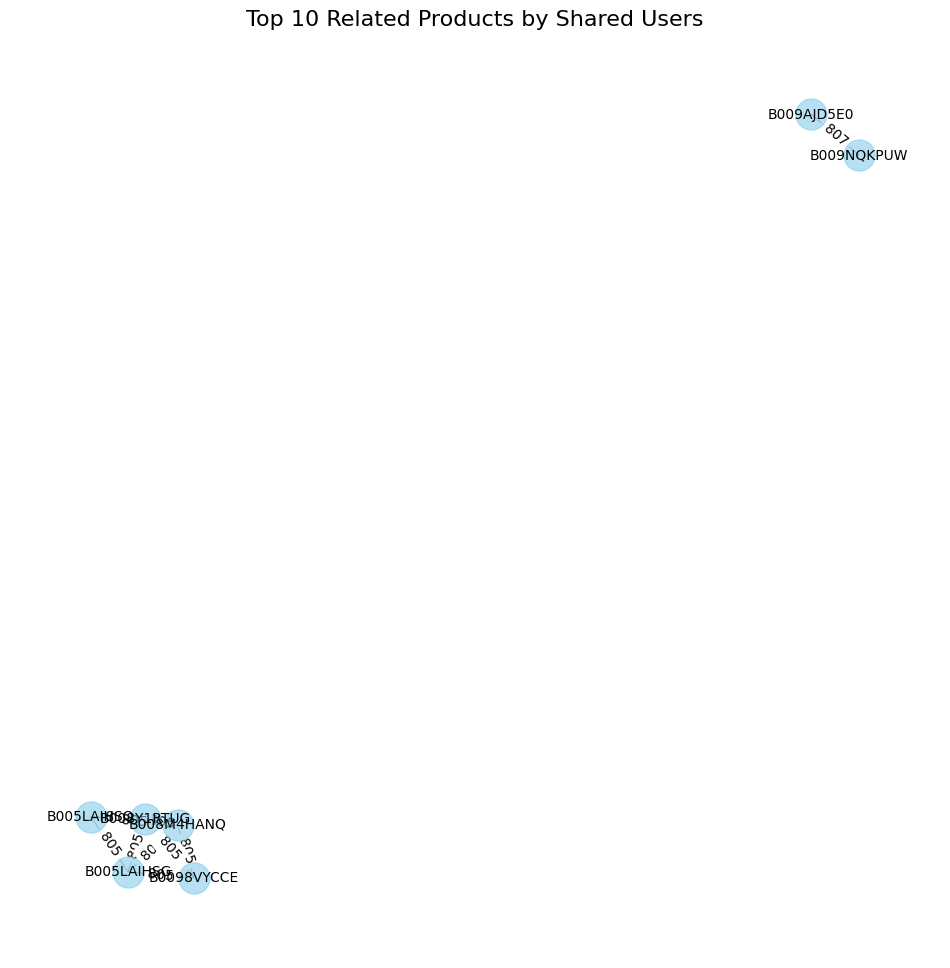

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

# Extract product nodes (products in the bipartite graph)
product_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the unweighted product-product graph by projecting the bipartite graph onto the product nodes
product_graph_unweighted = bipartite.projected_graph(G, product_nodes)

# Find shared users for each product pair and store it in a dictionary
shared_users = {}
for product1, product2 in product_graph_unweighted.edges():
    # Find the common users for each pair of products
    common_users = set(G.neighbors(product1)).intersection(G.neighbors(product2))
    shared_users[(product1, product2)] = common_users

# Top related products by shared users (unweighted edges)
top_pairs_unweighted = sorted(shared_users.items(), key=lambda x: len(x[1]), reverse=True)[:10]

# Create a subgraph for the top 10 related products
top_product_graph = nx.Graph()
for (product1, product2), users in top_pairs_unweighted:
    top_product_graph.add_edge(product1, product2, weight=len(users))

# Visualize the subgraph (top 10 related products)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(top_product_graph, seed=42)  # Layout for positioning nodes
nx.draw_networkx_nodes(top_product_graph, pos, node_size=500, node_color='skyblue', alpha=0.6)  # Draw nodes
nx.draw_networkx_edges(top_product_graph, pos, alpha=0.6, edge_color='gray')  # Draw edges
nx.draw_networkx_labels(top_product_graph, pos, font_size=10, font_color='black')  # Add labels (product IDs)

# Add edge labels for the number of shared users
edge_labels = nx.get_edge_attributes(top_product_graph, 'weight')
nx.draw_networkx_edge_labels(top_product_graph, pos, edge_labels=edge_labels)

# Add title and display the plot
plt.title("Top 10 Related Products by Shared Users", fontsize=16)
plt.axis('off')  # Hide the axes for better aesthetics
plt.show()


In [52]:
from networkx.algorithms import bipartite

# Extract product nodes
product_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the product-product graph
product_graph = bipartite.weighted_projected_graph(G, product_nodes)

# Top related products by shared users
top_pairs = sorted(product_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
print("Top related products by shared users:", top_pairs)


Top related products by shared users: [('B009NQKPUW', 'B009AJD5E0', {'weight': 812}), ('B008Y1RTUG', 'B005LAIHSQ', {'weight': 806}), ('B008Y1RTUG', 'B005LAIHSG', {'weight': 806}), ('B008Y1RTUG', 'B008M4HANQ', {'weight': 806}), ('B008Y1RTUG', 'B0098VYCCE', {'weight': 806}), ('B0098VYCCE', 'B005LAIHSQ', {'weight': 806}), ('B0098VYCCE', 'B005LAIHSG', {'weight': 806}), ('B0098VYCCE', 'B008M4HANQ', {'weight': 806}), ('B008M4HANQ', 'B005LAIHSQ', {'weight': 806}), ('B008M4HANQ', 'B005LAIHSG', {'weight': 806})]


In [54]:
# Check if the bipartite graph is connected
if nx.is_connected(G):
    print("The graph is connected.")

    # Find connected components and visualize the largest connected component
    connected_components = list(nx.connected_components(G))
    largest_component = max(connected_components, key=len)
    largest_subgraph = G.subgraph(largest_component)

    # Visualize the largest connected component (using spring layout)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(largest_subgraph, seed=42)
    nx.draw(largest_subgraph, pos, with_labels=False, node_size=50, alpha=0.6, edge_color='gray')
    plt.title("Largest Connected Component of the Graph")
    plt.show()
else:
    print("The graph is not connected.")
    


The graph is not connected.


In [57]:
# Analyze degree centrality in each connected component
for i, component in enumerate(connected_components[:100]):  # Limit to first 3 components for example
    subgraph = G.subgraph(component)
    degree_analysis = sorted(subgraph.degree(), key=lambda x: x[1], reverse=True)
    print(f"Top users/products in connected component {i + 1}:", degree_analysis[:10])


Top users/products in connected component 1: [('ANGH6401L9Y0T', 4090), ('A2B3Z2QHW3V35S', 2225), ('AV6QDP8Q0ONK4', 1806), ('A3QLAOOTFEHCJI', 1267), ('A1X1CEGHTHMBL1', 1243), ('AY12DBB0U420B', 1209), ('A1G0VFQ9198IUF', 1151), ('ANCOMAI0I7LVG', 1056), ('A1TJIJKKN15KR9', 1023), ('A27H9DOUGY9FOS', 894)]
Top users/products in connected component 2: [('A33FAH3K20SX5G', 4), ('B00005EAXH', 1), ('B00004ZBX8', 1), ('B000053V4P', 1), ('B00004U104', 1)]
Top users/products in connected component 3: [('B000MGBLGY', 10), ('A3VTW30NQQ9Q86', 8), ('AK9NE4POU3OBM', 7), ('B0000CBY1B', 2), ('B00005JK45', 2), ('6305112878', 2), ('B000BMY2LU', 2), ('B00004CJSB', 2), ('6300147436', 2), ('B0000399WR', 2)]
Top users/products in connected component 4: [('A1HA3NL7L8V7AH', 8), ('A1Q7YZHN76FO38', 5), ('B001O0TWYA', 2), ('B001O0TWZ4', 2), ('B002LTC1GE', 2), ('B002IX73DE', 2), ('B001O0TWYK', 2), ('B00009Y3NC', 1), ('B001LQZQME', 1), ('B001LQWQ2W', 1)]
Top users/products in connected component 5: [('A34I6JWT6FF7U8', 3